Compiling model...
'compile' took 0.705746 s

Training model...

Step      Train loss                        Test loss                         Test metric   
0         [3.43e+02, 5.91e+01, 1.84e-01]    [4.27e+02, 5.91e+01, 1.84e-01]    [1.00e+00]    


/home/oscar-rincon/miniconda3/envs/scattering-problem-env/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1716578970623/work/aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


1000      [2.79e+02, 7.75e+01, 5.97e+00]    [3.09e+02, 7.75e+01, 5.97e+00]    [1.22e+00]    
2000      [1.47e-01, 4.52e-03, 2.41e-02]    [1.61e-01, 4.52e-03, 2.41e-02]    [2.38e-02]    
3000      [2.22e-01, 8.44e-03, 1.89e-02]    [2.19e-01, 8.44e-03, 1.89e-02]    [2.12e-02]    
4000      [4.15e-02, 1.02e-03, 4.50e-03]    [4.98e-02, 1.02e-03, 4.50e-03]    [1.06e-02]    
5000      [1.02e+00, 4.41e-02, 1.02e-01]    [9.88e-01, 4.41e-02, 1.02e-01]    [5.13e-02]    

Best model at step 4000:
  train loss: 4.70e-02
  test loss: 5.53e-02
  test metric: [1.06e-02]

'train' took 47.298740 s

Saving loss history to /home/oscar-rincon/scattering-problem/deepxde/loss.dat ...
Saving training data to /home/oscar-rincon/scattering-problem/deepxde/train.dat ...
Saving test data to /home/oscar-rincon/scattering-problem/deepxde/test.dat ...


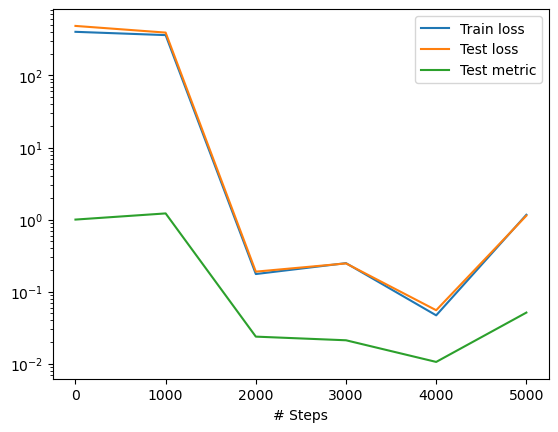

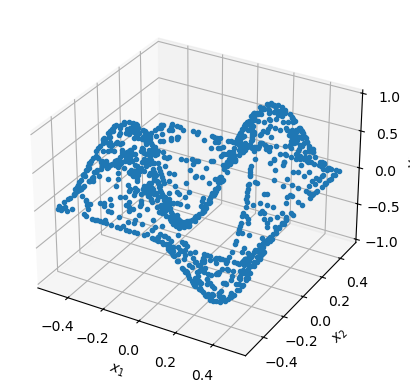

Relative error =  0.04974641035116133


/tmp/ipykernel_93819/1074295336.py:150: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap("seismic"),
/tmp/ipykernel_93819/1074295336.py:162: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap("seismic"),


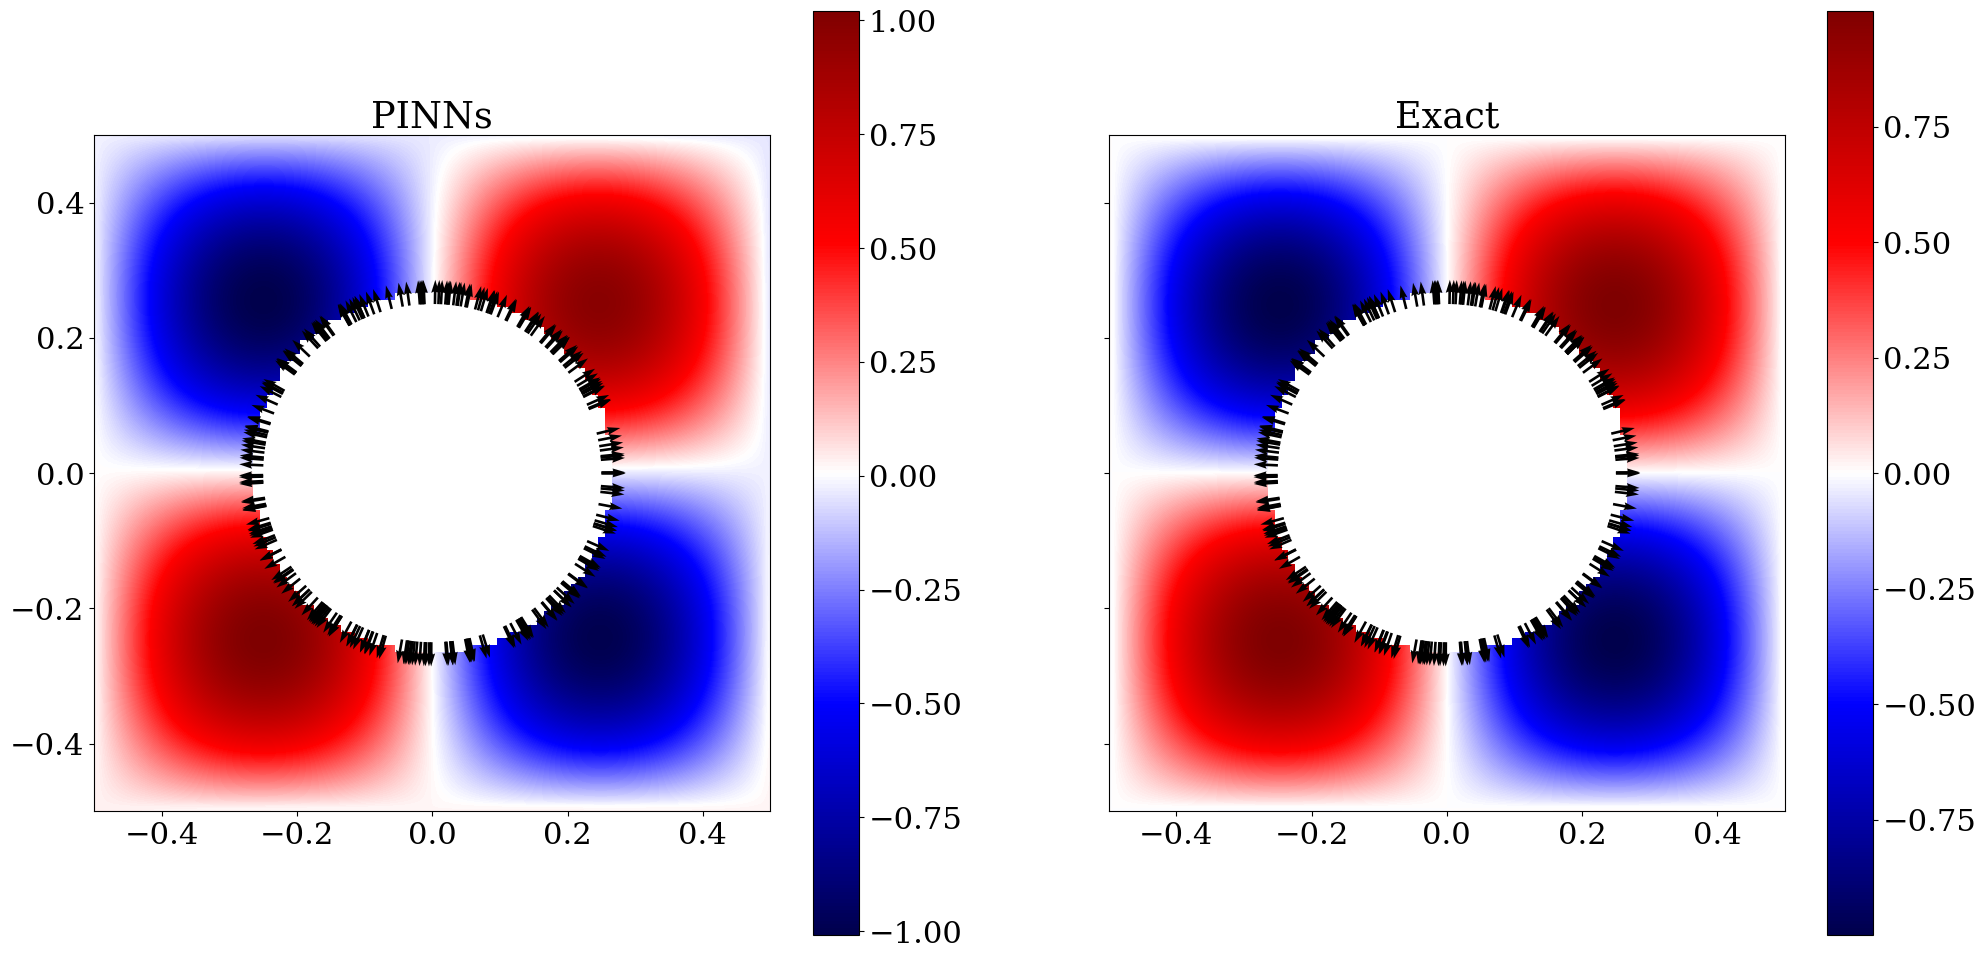

In [8]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch, paddle"""
import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np


# General parameters
n = 1
length = 1
R = 1 / 4

precision_train = 15
precision_test = 30

weight_inner = 10
weight_outer = 100
iterations = 5000
learning_rate = 1e-3
num_dense_layers = 3
num_dense_nodes = 350
activation = "sin"

k0 = 2 * np.pi * n
wave_len = 1 / n

# Define sine function
if dde.backend.backend_name in ["tensorflow.compat.v1", "tensorflow"]:
    from deepxde.backend import tf

    sin = tf.sin
elif dde.backend.backend_name == "pytorch":
    import torch

    sin = torch.sin
elif dde.backend.backend_name == "paddle":
    import paddle

    sin = paddle.sin


def pde(x, y):
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_yy = dde.grad.hessian(y, x, i=1, j=1)
    f = k0**2 * sin(k0 * x[:, 0:1]) * sin(k0 * x[:, 1:2])
    return -dy_xx - dy_yy - k0**2 * y - f


def func(x):
    return np.sin(k0 * x[:, 0:1]) * np.sin(k0 * x[:, 1:2])


def boundary(_, on_boundary):
    return on_boundary


def neumann(x):
    grad = np.array(
        [
            k0 * np.cos(k0 * x[:, 0:1]) * np.sin(k0 * x[:, 1:2]),
            k0 * np.sin(k0 * x[:, 0:1]) * np.cos(k0 * x[:, 1:2]),
        ]
    )

    normal = -inner.boundary_normal(x)
    normal = np.array([normal]).T
    result = np.sum(grad * normal, axis=0)
    return result


outer = dde.geometry.Rectangle([-length / 2, -length / 2], [length / 2, length / 2])
inner = dde.geometry.Disk([0, 0], R)


def boundary_outer(x, on_boundary):
    return on_boundary and outer.on_boundary(x)


def boundary_inner(x, on_boundary):
    return on_boundary and inner.on_boundary(x)


geom = outer - inner

hx_train = wave_len / precision_train
nx_train = int(1 / hx_train)

hx_test = wave_len / precision_test
nx_test = int(1 / hx_test)

bc_inner = dde.icbc.NeumannBC(geom, neumann, boundary_inner)
bc_outer = dde.icbc.DirichletBC(geom, func, boundary_outer)

data = dde.data.PDE(
    geom,
    pde,
    [bc_inner, bc_outer],
    num_domain=nx_train**2,
    num_boundary=16 * nx_train,
    solution=func,
    num_test=nx_test**2,
)

net = dde.nn.FNN(
    [2] + [num_dense_nodes] * num_dense_layers + [1], activation, "Glorot uniform"
)

model = dde.Model(data, net)

loss_weights = [1, weight_inner, weight_outer]
model.compile(
    "adam", lr=learning_rate, metrics=["l2 relative error"], loss_weights=loss_weights
)

losshistory, train_state = model.train(iterations=iterations)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

# Plot the solution over a square grid with 100 points per wavelength in each direction
Nx = int(np.ceil(wave_len * 100))
Ny = Nx

# Grid points
xmin, xmax, ymin, ymax = [-length / 2, length / 2, -length / 2, length / 2]
plot_grid = np.mgrid[xmin : xmax : Nx * 1j, ymin : ymax : Ny * 1j]
points = np.vstack(
    (plot_grid[0].ravel(), plot_grid[1].ravel(), np.zeros(plot_grid[0].size))
)

points_2d = points[:2, :]
u = model.predict(points[:2, :].T)
u = u.reshape((Nx, Ny))

ide = np.sqrt(points_2d[0, :] ** 2 + points_2d[1, :] ** 2) < R
ide = ide.reshape((Nx, Nx))

u_exact = func(points.T)
u_exact = u_exact.reshape((Nx, Ny))
diff = u_exact - u
error = np.linalg.norm(diff) / np.linalg.norm(u_exact)
print("Relative error = ", error)

plt.rc("font", family="serif", size=22)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(24, 12))

matrix = np.fliplr(u).T
matrix = np.ma.masked_where(ide, matrix)
pcm = ax1.imshow(
    matrix,
    extent=[-length / 2, length / 2, -length / 2, length / 2],
    cmap=plt.cm.get_cmap("seismic"),
    interpolation="spline16",
    label="PINN",
)

fig.colorbar(pcm, ax=ax1)

matrix = np.fliplr(u_exact).T
matrix = np.ma.masked_where(ide, matrix)
pcm = ax2.imshow(
    matrix,
    extent=[-length / 2, length / 2, -length / 2, length / 2],
    cmap=plt.cm.get_cmap("seismic"),
    interpolation="spline16",
    label="Exact",
)

ax1.set_title("PINNs")
ax2.set_title("Exact")
fig.colorbar(pcm, ax=ax2)

# Add the boundary normal vectors
p = inner.random_boundary_points(16 * nx_train)
px, py = p.T
nx, ny = inner.boundary_normal(p).T
ax1.quiver(px, py, nx, ny)
ax2.quiver(px, py, nx, ny)
plt.savefig("plot_manufactured.pdf")